In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en


Redirecting output to ‘wget-log’.
Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
    100% |████████████████████████████████| 37.4MB 11.3MB/s 
  Running setup.py install for en-core-web-sm ... - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



Тут придется авторизировать запрос к гугл драйву, извините.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

# Организационное

Страница курса: https://github.com/DanAnastasyev/DeepNLP-Course

Чатик: https://t.me/joinchat/DgDT4RLYhsTh_x6fRvfMjQ

Примерный план:

1. Введение
2. PyTorch, word embeddings
3. RNN 1, text classification
4. RNN 2, sequence labeling
5. RNN 3, text generation, language models
6. CNN, text classification
7. Machine translation, attention
8. Transformers
9. Dialogue systems 1, tagging + classification, multi-task learning
10. Dialogue systems 2, DSSM
11. Transfer learning
12. Tensorflow + xla/aot or Meta BiLSTM (?)

... and something else

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [4]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

Test accuracy = 71.42%


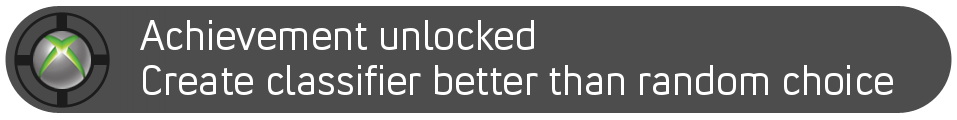

In [5]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'well', 'impression', 'emotionally', 'favorite', 'favourite', 'athmosphere', 'brilliant' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap', 'shit', 'bad', 'spoilers', 'fistful', 'sake', 'waste', 'save' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

---

*Код классификации основан на том, каких слов в тексте больше: положительных или отрицательных.*

---

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [6]:
import re

pattern = re.compile('<[^>]+>')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [0]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Посмотрим на слова, попавшие в словарь:

In [10]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

Попробуем кого-нибудь таки сконвертировать

In [11]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74843 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40105812  0.40105812  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [13]:
model.fit(train_df['review'], train_df['is_positive'])

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [14]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.66%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [15]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.586,refreshing
+1.411,wonderfully
+1.354,erotic
+1.297,funniest
+1.288,perfect
+1.282,excellent
+1.279,carrey
+1.261,superb
+1.250,surprisingly
+1.249,appreciated


Посмотрим на конкретные примеры его работы:

In [16]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [17]:
print('Positive' if test_df['is_positive'].iloc[0] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [18]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.27%


In [20]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+7.553,great
+6.153,excellent
+5.121,best
+4.813,perfect
+4.653,wonderful
+4.132,amazing
+3.995,well
+3.838,loved
+3.773,favorite
+3.770,fun


In [21]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [22]:
print('Positive' if test_df['is_positive'].iloc[0] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


In [23]:
preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

---

*Tf-idf vectorizer* делает редкие слова более важными, чем те, что встречаются постоянно. Как следствие, нам больше не нужно задумыватсья о *stop words*.

В нашем случае важные слова, полученные с  помощью *tf-dif vectorizer* больше похоже на те, какие ожидаешь увидеть (очевидно, что слово *great* сильнее характеризует текст как положительный, чем слово  *flight*).

Проблемы - теперь именованные сущности имеют больший вес (например, *tarzan*, *jane*, *hugh hadson* в первой рецензии).

---

### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.65%


In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.74%


---

Рассматривая биграмы, мы смогли улучшить точность классификации: *nice waste* - раньше эта комбинация была сильно отрицательной, а теперь классификатор понимает, что это не так.

Увеличив *ngram_range* до 3, точность уменьшилась. Видимо, переобучились под обучающую выборку.

Вообще идея такая, что при увеличении *ngram_range* точность сначала должна расти, а затем должна начать падать - с какого-то момента *ngram*'ы станут слишком большими (например, целое предложение) и перестанут помогать классифицировать тексты (маловероятно, что и в обучающей, и в тестовой выборке будет одинаковое предложение).

---

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.86%


In [27]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [28]:
print('Positive' if test_df['is_positive'].iloc[32] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[32], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


In [29]:
print('Positive' if test_df['is_positive'].iloc[17] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[17], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


---

*В 32 отзыве видим слово `like`  с отрицательной окраской, а в 17 - `liked` с положительной (в 17 так же есть `like` с отрицательной окраской).*

---

In [0]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [31]:
for token in docs[0]:
    if token.text != token.lemma_:
      print(token.text, token.lemma_)

Dreamgirls dreamgirl
its -PRON-
Tony tony
wins win
Broadway broadway
has have
been be
musicals musical
However however
is be
hands hand
it -PRON-
fleshed flesh
polished polish
Unfortunately unfortunately
transfers transfer
is be
its -PRON-
weaknesses weakness
First first
has have
been be
points point
does do
There there
are be
lots lot
songs song
them -PRON-
are be
The the
closest close
tunes tune
are be
One one
Night night
Only only
And and
I -PRON-
Am be
Telling tell
You -PRON-
That that
I -PRON-
Am be
Not not
Going go
is be
it -PRON-
is be
Effie effie
Jennifer jennifer
Hudson hudson
The the
is be
produced produce
characters character
are be
There there
is be
moments moment
watching watch
Jamie jamie
Foxx foxx
Svengali svengali
his -PRON-
acts act
takes take
tries try
him -PRON-
his -PRON-
having have
been be
Beyonce beyonce
Knowles knowles
is be
sings sing
her -PRON-
songs song
is be
stuck stick
is be
Anika anika
Noni noni
Rose rose
Dreamgirls dreamgirls
has have
Eddie eddie
Murphy 

Весь этот процесс очень долгий, поэтому я предподсчитал всё.

In [0]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)
    
with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

**Задание** Сделайте классификатор на лемматизированных текстах.

In [0]:
def lemmatize(texts):
    return [' '.join([words[1] for words in text[0]]) for text in texts]

In [0]:
train_df_lemmatized = train_df.copy()
test_df_lemmatized = test_df.copy()

train_df_lemmatized.review = lemmatize(train_docs)
test_df_lemmatized.review = lemmatize(test_docs)

In [35]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df_lemmatized['review'], train_df_lemmatized['is_positive'])

eval_model(model, test_df_lemmatized)

Test accuracy = 88.50%


Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [36]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [37]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
def stem(texts):
    return [' '.join([stemmer.stem(word) for word in word_tokenize(sentence)]) for sentence in texts]

In [0]:
train_df_stemmed = train_df.copy()
test_df_stemmed = test_df.copy()

train_df_stemmed.review = stem(train_df_stemmed.review)
test_df_stemmed.review = stem(test_df_stemmed.review)

In [40]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df_stemmed['review'], train_df_stemmed['is_positive'])

eval_model(model, test_df_stemmed)

Test accuracy = 88.63%


### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [41]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [0]:
def delete_entitites(texts, docs, entity='PERSON'):
    new_texts = []
    
    for i in range(len(docs)):
        new_string = ''
        last = 0
        
        for it in docs[i][1]:
            if it[2] == entity:
                new_string += texts[i][last:it[0]]
                last = it[1]
        new_string += texts[i][last:]
        
        new_texts.append(new_string)
   
    return np.array(new_texts)

In [0]:
train_df_ner = train_df.copy()
test_df_ner = test_df.copy()

train_df_ner.review = delete_entitites(train_df_ner.review, train_docs)
test_df_ner.review = delete_entitites(test_df_ner.review, test_docs)

In [44]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df_ner['review'], train_df_ner['is_positive'])

eval_model(model, test_df_ner)

Test accuracy = 88.78%


## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

<a list of 223 Patch objects>

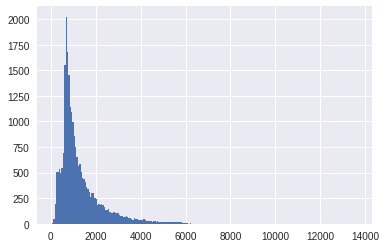

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text)), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [46]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26782


**Задание** Сконвертируйте данные

In [0]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)

    for i, text in enumerate(texts):
        tokens = text.lower().split()[:max_text_len]
        data[i, :len(tokens)] = [word2idx.get(token, 1) for token in tokens]

    return data

X_train = convert(train_df.review, word2idx, 2000)
X_test = convert(test_df.review, word2idx, 2000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [58]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1),
    GlobalMaxPooling1D(),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 64)          1714048   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1998, 128)         24704     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,738,881
Trainable params: 1,738,881
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=3, 
          validation_data=(X_test, test_df.is_positive))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 18s 721us/step - loss: 0.5407 - acc: 0.7388 - val_loss: 0.3644 - val_acc: 0.8416
Epoch 2/3
25000/25000 [==============================] - 17s 679us/step - loss: 0.2847 - acc: 0.8817 - val_loss: 0.2914 - val_acc: 0.8788
Epoch 3/3
25000/25000 [==============================] - 17s 679us/step - loss: 0.1636 - acc: 0.9433 - val_loss: 0.2810 - val_acc: 0.8830


**Задание** Подсчитайте качество модели на тесте

In [50]:
model.evaluate(X_test, test_df.is_positive)

25000/25000 [==============================] - 5s 184us/step


[0.49759211559057237, 0.86424]

## Немного математики

Вспомним, как работает логистическая регрессия, которой мы тут столько пользовались.

Пригодятся:

In [0]:
np.random.seed(42)
w, X, y = np.random.random(10), np.random.random((11, 10)), 2 * (np.random.randint(0, 2, 11) - 0.5)

Это обычная линейная функция

$$h_w(X) = \sigma(X w),$$
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Подсчитайте ее:

In [0]:
def forward(X, w):
    """ Функция, вычисляющая h(X, w)
    X - матрица (n, m)
    w - вектор (m,)
    """
    return 1 / (1 + np.exp(-X @ w))

Функция потерь 
$$J(w)  = \frac{1}{m} \left(-y^T \text{log}(h_w) - (1-y)^T \text{log}(1 - h_w)\right)$$

Для оптимизации с SGD нужно считать градиент по функции потерь
$\frac{\partial J(w)}{\partial w}$.

**Задание** Подсчитайте их.

---

Приведу вывод формулы для вычисления градиента функции потерь.

Перепишем функцию в следующем виде:

$$J(w)  = \frac{1}{m} \left(-\sum_{i=1}^{n} y^{(i)} log\left(\sigma(X^{(i)}w)\right) - \sum_{i=1}^{n} (1 - y^{(i)}) log\left(1 - \sigma(X^{(i)}w)\right)\right)$$

Распишем подробнее некоторые моменты:

$$X^{(i)}w = \sum_{j=1}^{m} X^{(i)}_{j}w_{j}$$

$$\sigma(X^{(i)}w) = \cfrac{1}{1 + e^{-\sum_{j=1}^{m} X^{(i)}_{j}w_{j}}}$$

$$\frac{\partial \sigma(X^{(i)}w)}{\partial w_{k}} = \cfrac{1}{\left(1 + e^{-\sum_{j=1}^{m} X^{(i)}_{j}w_{j}}\right)^{2}} \cdot e^{-\sum_{j=1}^{m} X^{(i)}_{j}w_{j}} \cdot X^{(i)}_{k} = \sigma(X^{(i)}w)^{2} \cdot e^{-\sum_{j=1}^{m} X^{(i)}_{j}w_{j}} \cdot X^{(i)}_{k}$$

Теперь можно записать следующее:

$$\frac{\partial J(w)}{\partial w_{k}} = \frac{1}{m} \left(-\sum_{i=1}^{n} y^{(i)} \frac{1}{\sigma(X^{(i)}w)} \sigma(X^{(i)}w)^{2} \cdot e^{-\sum_{j=1}^{m} X^{(i)}_{j}w_{j}} \cdot X^{(i)}_{k} + \sum_{i=1}^{n} (1 - y^{(i)}) \frac{1}{1 - \sigma(X^{(i)}w)} \sigma(X^{(i)}w)^{2} \cdot e^{-\sum_{j=1}^{m} X^{(i)}_{j}w_{j}} \cdot X^{(i)}_{k}\right) =$$
$$\frac{1}{m} \sum_{i=1}^{n}\left[\left(-y^{(i)} \sigma(X^{(i)}w) +(1 - y^{(i)}) \frac{\sigma(X^{(i)}w)^{2}}{1 - \sigma(X^{(i)}w)}\right) \cdot e^{-X^{(i)}w} \cdot X^{(i)}_{k}\right] = \frac{1}{m} \sum_{i=1}^{n}\left(\sigma(X^{(i)}w) - y^{(i)}\right)X^{(i)}_{k}$$

Теперь можно выписать общую формулу для градиента функции потерь:

$$\nabla J(w) = \frac{1}{m} \left(h_{w}(X) - y\right)^{T}X$$

---

In [53]:
def loss(X, w, y):
    """ Функция потерь
    X - матрица (n, m)
    w - вектор (m,)
    y - вектор (n,)
    """
    return (-y @ np.log(forward(X, w)) - (1 - y) @ np.log(1 - forward(X, w))) / X.shape[1]


def gradient(X, w, y):
    """ Градиент функции потерь по w
    X - матрица (n, m)
    w - вектор (m,)
    y - вектор (n,)
    """
    return (forward(X, w) - y) @ X / X.shape[1]


print('loss = ', loss(X, w, y))
print('gradient = ', gradient(X, w, y))

assert gradient(X, w, y).shape == w.shape

loss =  3.2755940394340555
gradient =  [0.65351203 0.67501285 0.49827179 0.76251335 0.74332428 0.77202988
 0.56349032 0.58497662 0.49315362 0.2398401 ]


Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей: 

$$[\nabla f(x)]_i \approx \frac{f(x + \varepsilon \cdot e_i) - f(x)}{\varepsilon}$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\varepsilon \approx 10^{-8}$

In [54]:
def grad_finite_diff(func, x, eps=1e-8):
    """
    w - вектор (m,)
    func - скалярная функция от векторного аргумента w, func(w) = число
    eps - константа для проверки градиента
    """
    x, fval, dnum = x.astype(np.float64), func(x), np.zeros_like(x)
    
    E = np.eye(x.shape[0])
    deltas = np.array([func(x + eps * E[i]) for i in range(x.shape[0])])
    return (deltas - fval) / eps

mat_grad = gradient(X, w, y)
num_grad = grad_finite_diff(lambda w: loss(X, w, y), w)

err = np.max(np.abs(mat_grad - num_grad))
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')

err =  1.6307688732730696e-07 ok


В итоге получим такой класс:

In [0]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        self._w = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            grad = gradient(X, self._w, y)
            self._w -= self.lr * grad
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return forward(X, self._w)
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

Посмотрим, как всё работает на простых датасетах:

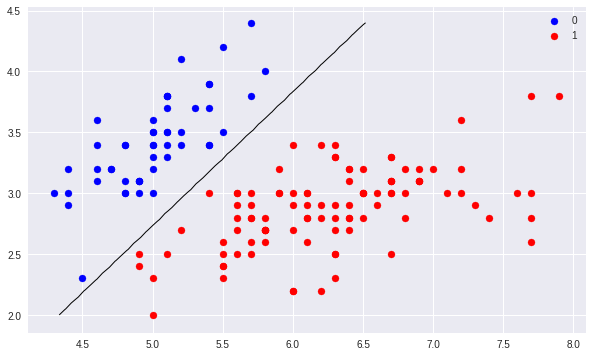

In [56]:
from sklearn.datasets import make_moons, load_iris

iris = load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

model = LogisticRegression(lr=0.1, num_iter=300000)
model.fit(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()

x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black')

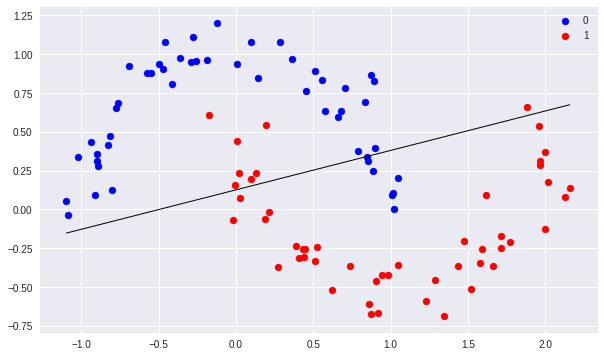

In [57]:
X, y = make_moons(noise=0.1)

model = LogisticRegression()
model.fit(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()

x1_min, x1_max = X[:,0].min(), X[:,0].max()
x2_min, x2_max = X[:,1].min(), X[:,1].max()
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

grid = np.c_[xx1.ravel(), xx2.ravel()]

probs = model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black')

# Сдача задания

Сдаем через [форму](https://goo.gl/forms/TWl14R42ddDPvZLU2).

И можно заполнить [анонимный опрос](https://goo.gl/forms/RII9cRcwoaJjPr2G3).